<a href="https://colab.research.google.com/github/Salma-Kassem/DeepLearning/blob/main/MNIST_RBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST Reconstruction with Bernoulli Restricted Boltzmann Machines (RBM)

Disclaimer: https://github.com/MichelDeudon/RBM-for-MNIST/blob/master/main.ipynb
https://github.com/meownoid/tensorflow-rbm

In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import os
import numpy as np
import keras
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt

Instructions for updating:
non-resource variables are not supported in the long term


## RBM Class

In [ ]:
def sample(probabilities, mode='bernoulli'):
    ''' Sample a tensor based on the probabilities (A tensor given by get_probabilities)'''
    if mode=='bernoulli':
        return tf.floor(probabilities + tf.random.uniform(tf.shape(probabilities), 0, 1))
    elif mode=='gaussian':
        return tf.add(probabilities, tf.random.normal(tf.shape(probabilities), mean=0.0, stddev=1.)) # Add noise to the original probabilities



# Simple RBM class
class RBM:

    def __init__(self, n_visible, n_hidden, lr, epochs, mode='bernoulli'):
        ''' Initialize a model for an RBM with one layer of hidden units '''
        self.mode = mode # bernoulli or gaussian RBM
        self.n_hidden = n_hidden #  Number of hidden nodes
        self.n_visible = n_visible # Number of visible nodes
        self.lr = lr # Learning rate for the CD algorithm
        self.epochs = epochs # Number of iterations to run the algorithm for

        # Initialize weights and biases
        with tf.name_scope('Weights'):
            self.W = tf.Variable(tf.random.normal([self.n_visible, self.n_hidden], mean=0., stddev=4 * np.sqrt(6. / (self.n_visible + self.n_hidden))), name="weights")
        self.vb = tf.Variable(tf.zeros([1, self.n_visible]),tf.float32, name="visible_bias")
        self.hb = tf.Variable(tf.zeros([1, self.n_hidden]),tf.float32, name="hidden_bias")


    def get_probabilities(self, layer, val):
        ''' Return a tensor of probabilities associated with the layer specified'''
        if layer == 'hidden':
            with tf.name_scope("Hidden_Probabilities"):
                if self.mode=='bernoulli':
                    return tf.nn.sigmoid(tf.matmul(val, self.W) + self.hb)
                elif self.mode=='gaussian':
                    return tf.matmul(val, self.W) + self.hb

        elif layer == 'visible':
            with tf.name_scope("Visible_Probabilities"):
                return tf.nn.sigmoid(tf.matmul(val, tf.transpose(self.W)) + self.vb)


    def CD(self, v, K=1):
        ''' K-step Contrastive Divergence using Gibbs sampling. Return parameters update. '''
        with tf.name_scope("Contrastive_Divergence"):
            h_prob = self.get_probabilities('hidden', v)
            h_state = sample(h_prob, mode=self.mode)
            pos_divergence = tf.matmul(tf.transpose(v), h_prob) # Positive Divergence + h(v).v^T

            fake_v_prob = self.get_probabilities('visible', h_state)
            fake_v_state = fake_v_prob #sample(fake_v_prob)

            fake_h_prob = self.get_probabilities('hidden', fake_v_state)
            fake_h_state = sample(fake_h_prob, mode=self.mode)

            for i in range(K-1): # Number of steps to run the algorithm

                fake_v_prob = self.get_probabilities('visible', fake_h_state)
                fake_v_state = fake_v_prob #sample(fake_v_prob)

                fake_h_prob = self.get_probabilities('hidden', fake_v_state)
                fake_h_state = sample(fake_h_prob, mode=self.mode)

            neg_divergence = tf.matmul(tf.transpose(fake_v_state), fake_h_prob) # Negative Divergence - h(v').v'^T

            dW = pos_divergence-neg_divergence
            dvb = v-fake_v_state
            dhb = h_prob-fake_h_prob

            # Similarity between reconstructed visible layer and input during training.
            self.rec_error = tf.reduce_mean(tf.squared_difference(v, fake_v_state))

            self.div = tf.reduce_mean(tf.abs(dW))

            return dW, dvb, dhb


    def update(self, v, K=1):
        batch_size = tf.cast(tf.shape(v)[0], tf.float32) # batch size
        dW, dvb, dhb = self.CD(v, K=K) # contrastive divergence

        delta_w = (self.lr/batch_size)*dW # weight gradient
        delta_vb = (self.lr/batch_size)*(tf.reduce_sum(dvb, 0, keepdims =True)) # visible bias gradient
        delta_hb = (self.lr/batch_size)*(tf.reduce_sum(dhb, 0, keepdims =True)) # hidden bias gradient

        train_op = [self.W.assign_add(delta_w), self.vb.assign_add(delta_vb), self.hb.assign_add(delta_hb)]
        return train_op


    def gibbs(self, steps, v):
        ''' Use the Gibbs sampler for a network of hidden and visible units. Return a sampled version of the input'''
        with tf.name_scope("Gibbs_sampling"):
            for i in range(steps): # Number of steps to run the algorithm
                hidden_p = self.get_probabilities('hidden', v) # v: input data
                h = sample(hidden_p, mode=self.mode)

                visible_p = self.get_probabilities('visible', h)
                v = visible_p
                #v = sample(visible_p)
            return visible_p


    def get_feature_map(self):
        ''' Return hidden features'''
        ft_map = {}
        for k in range(self.n_hidden):
            ft_map[k] = self.get_probabilities('visible', tf.expand_dims(tf.one_hot(k+1, self.n_hidden),0))
        return ft_map

## Initialize RBM

In [ ]:
# MNIST dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Initialize RBM Model for MNIST reconstruction
rbm_model = RBM(n_visible = 784, n_hidden = 144, lr = tf.constant(0.05, tf.float32), epochs = 5, mode='bernoulli')
#rbm_model = RBM(n_visible = 784, n_hidden = 144, lr = tf.constant(0.003, tf.float32), epochs = 10000, mode='gaussian')

# Placeholder for the visible layer of the RBM computation graph.
v = tf.placeholder(tf.float32, shape=[None, rbm_model.n_visible], name="visible_layer")

11501568/11490434 [==============================] - 0s 0us/step


In [ ]:
x_train = x_train.reshape(x_train.shape[0], -1) / 255.
x_test = x_test.reshape(x_test.shape[0], -1) / 255.
print(x_train.shape, x_test.shape)

(60000, 784) (10000, 784)


## Update parameters w/ K-step Contrastive Divergence using Gibbs sampling

In [ ]:
# Update rule
k=1
train_op = rbm_model.update(v, K=k)

## Launch session

In [ ]:
# Create session.
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

## Train model

In [ ]:
def show_digit(original, fake):
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    ax1.imshow(original.reshape((28,28)),cmap = plt.cm.gray)
    ax1.set_title('Original digit')
    ax2.imshow(fake.reshape((28,28)),cmap = plt.cm.gray)
    ax2.set_title('Sampled digit')
    plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


  0%|          | 0/5 [00:00<?, ?it/s]

Reconstruction error at step 0: 0.335


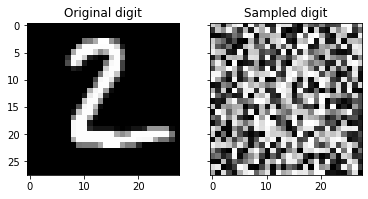

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


  0%|          | 0/1875 [00:00<?, ?it/s]

Reconstruction error at step 1: 0.021


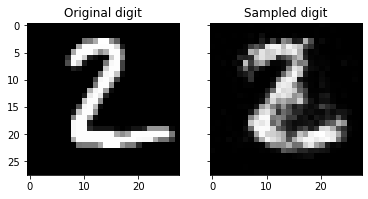

  0%|          | 0/1875 [00:00<?, ?it/s]

Reconstruction error at step 2: 0.018


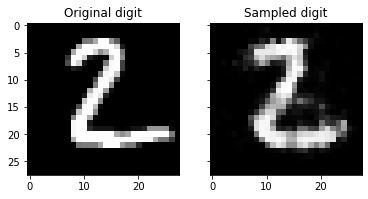

  0%|          | 0/1875 [00:00<?, ?it/s]

Reconstruction error at step 3: 0.016


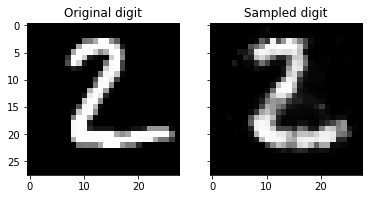

  0%|          | 0/1875 [00:00<?, ?it/s]

Reconstruction error at step 4: 0.015


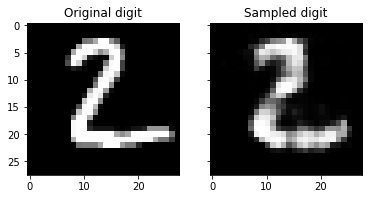

  0%|          | 0/1875 [00:00<?, ?it/s]

In [ ]:
batch_size = 32

for epoch in tqdm_notebook(range(rbm_model.epochs)):
    result = sess.run([rbm_model.rec_error], feed_dict = {v: x_test})
    print("Reconstruction error at step {}: {:.3f}".format(epoch, result[0]))
    test_image = x_test[1] # from test distribution
    sample_test = rbm_model.gibbs(1, v=v).eval(session=sess, feed_dict={v: test_image.reshape(1,-1).astype(np.float32)})
    show_digit(original=test_image, fake=sample_test)
    for batch_ind in tqdm_notebook(range(0, len(x_train), batch_size)): # 0 32/ 32 64/ ...
        next_batch = batch_ind + batch_size
        batchXs = x_train[batch_ind:next_batch]
        sess.run(train_op, feed_dict = {v: batchXs})

## Visualize hidden features

In [ ]:
def plot_features(ft_map):
    """ Plot MNIST features in a table."""
    len_ = int(np.sqrt(rbm_model.n_hidden))
    fig = plt.figure()
    features = [ft_map[k] for k in range(rbm_model.n_hidden)]
    for x in range(len_):
        for y in range(len_):
            ax = fig.add_subplot(len_, len_, len_*y+x+1)
            ax.matshow(features[len_*y+x].reshape((28,28)), cmap = plt.cm.gray)
            plt.xticks(np.array([]))
            plt.yticks(np.array([]))
    plt.show()

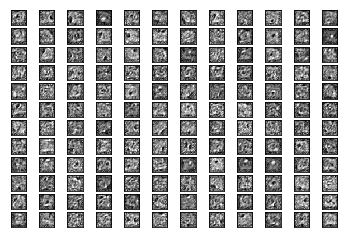

In [ ]:
ft_map = sess.run(rbm_model.get_feature_map())
plot_features(ft_map)

## Test the RBM for one sample step

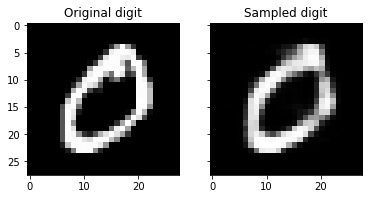

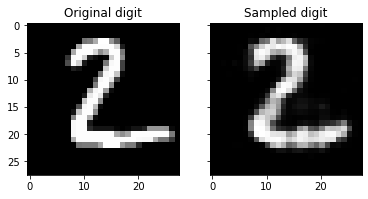

In [ ]:
train_image = x_train[1] # from train distribution
sample_train = rbm_model.gibbs(1, v=v).eval(session=sess, feed_dict={v: train_image.reshape(1,-1).astype(np.float32)})
show_digit(original=train_image, fake=sample_train)

test_image = x_test[1] # from test distribution
sample_test = rbm_model.gibbs(1, v=v).eval(session=sess, feed_dict={v: test_image.reshape(1,-1).astype(np.float32)})
show_digit(original=test_image, fake=sample_test)

tf.reset_default_graph()